<h1 style="color:pink; text-align:center;">New Credit Card Launch Analysis</h1>


<h2 style = "color:skyblue">import Important libraries and Data base Connection</h2>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as st
import statsmodels.stats.api as sms
import statsmodels.api as sm
import mysql.connector

In [ ]:
mysql_connection = mysql.connector.connect(
host = 'localhost',
user = 'root',
password = 'XXXXXXX',
database = 'XXXXXXX'
)


## testing the connection
df_customer = pd.read_sql("SELECT * FROM customers",mysql_connection)
df_transactions = pd.read_sql("SELECT * FROM transactions",mysql_connection)
df_credit_score = pd.read_sql("SELECT * FROM credit_profiles",mysql_connection)
df_avg_transactions_after_campaign = pd.read_sql("SELECT * FROM avg_transactions_after_campaign",mysql_connection)

C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\4243563391.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql("SELECT * FROM customers",mysql_connection)
C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\4243563391.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql("SELECT * FROM transactions",mysql_connection)
C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\4243563391.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_credit_score = pd.read_sql("SEL

<h3 style = "color:skyblue">Basics Validation</h3>

In [8]:
df_customer.head()
df_credit_score.head()
df_transactions.head()
df_avg_transactions_after_campaign.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,251.02,401.78
1,2023-09-11,250.77,326.16
2,2023-09-12,248.81,303.92
3,2023-09-13,255.90,363.29
4,2023-09-14,255.86,317.06


<h3 style = "color:pink;text-align:center">Customer Data Statistical Analysis</h3>

In [ ]:
df_customer.shape

(1000, 8)

In [76]:
df_customer.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married


In [94]:
df_customer.isnull().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

### Fill the Annual income null values based on the occupation wise median values.

In [95]:
## find the median values based on the occupation

customer_occupation_wise_median = df_customer.groupby('occupation',as_index=False).agg(occupation_wise_median = ('annual_income',lambda x : x.median()))
customer_occupation_wise_median


,occupation,occupation_wise_median
0,Accountant,65265.0
1,Artist,45794.0
2,Business Owner,261191.5
3,Consultant,58017.0
4,Data Scientist,135759.0
5,Freelancer,46759.0
6,Fullstack Developer,76774.0


In [96]:
def replace_annual_income(row):
  if(pd.isna(row['annual_income'])):
    return customer_occupation_wise_median[customer_occupation_wise_median['occupation'] == row['occupation']]['occupation_wise_median'].values[0]
  else:
    return row['annual_income']


df_customer['annual_income']  = df_customer.apply(replace_annual_income,axis=1)


In [97]:
df_customer.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

### Annual min amount is 100 S  as per the business owner

In [98]:
df_customer.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138916.765500
std,288.819436,15.666155,110969.408643
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


In [99]:
df_customer[df_customer['annual_income'] < 100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


#### update the annual amount which is < 100 $ to occupation wise median value 

In [100]:
def min_value_treatment(row):
  if(row['annual_income']<100):
    return customer_occupation_wise_median[customer_occupation_wise_median['occupation'] == row['occupation']]['occupation_wise_median'].values[0]
  else:
    return row['annual_income']

df_customer['annual_income'] = df_customer.apply(min_value_treatment,axis=1)

In [82]:
df_customer.loc[340]

cust_id                           341
name                      Priya Sinha
gender                         Female
age                                33
location                        Rural
occupation        Fullstack Developer
annual_income                 76774.0
marital_status                Married
Name: 340, dtype: object

#### Age column Validation and age range is 15 to 80.

<Axes: xlabel='age', ylabel='Count'>

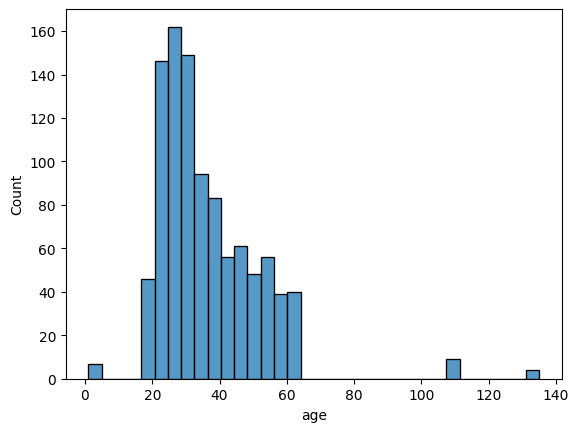

In [101]:
sn.histplot(df_customer['age'])

In [84]:
df_customer.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140483.548500
std,288.819436,15.666155,110463.002934
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


In [104]:
test= df_customer[(df_customer['age'] < 15)|(df_customer['age']>80)]
test.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married


In [106]:
df_customer_filter_age= df_customer[(df_customer['age'] >= 15) & (df_customer['age'] <= 80)]
df_customer_filter_age.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married
5,6,Arya Das,Male,22,City,Freelancer,44887.0,Married


#### occupation wise median age

In [105]:

occupation_wise_age_median = df_customer_filter_age.groupby('occupation',as_index=False).agg(median_age = ('age',lambda x : x.median()))
occupation_wise_age_median

,occupation,median_age
0,Accountant,31.5
1,Artist,26.0
2,Business Owner,51.0
3,Consultant,46.0
4,Data Scientist,32.0
5,Freelancer,24.0
6,Fullstack Developer,27.0


In [107]:
def get_age_treatment(row):
  if((row['age']>=15)|(row['age']<=80)):
    return occupation_wise_age_median[occupation_wise_age_median['occupation'] == row['occupation']]['median_age'].values[0]
  else:
    return row['age']
df_customer['age'] = df_customer.apply(get_age_treatment,axis=1)

In [88]:
df_customer.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2.0,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,46.0,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,24.0,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,46.0,City,Consultant,39406.0,Married


In [109]:
df_customer.loc[174]

cust_id                    175
name              Rohan Sharma
gender                    Male
age                       24.0
location                  City
occupation          Freelancer
annual_income          23723.0
marital_status         Married
Name: 174, dtype: object

In [110]:
bins = [17,25,48,65]
labels = [f'{start+1}-{end}' for start,end in zip(bins,bins[1:])]
df_customer['age_group'] = pd.cut(df_customer['age'],bins=bins,labels=labels)

<h2 style = "color:pink;text-align:center">Credit card Data Statistical Analysis</h2>

In [44]:
df_credit_score.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [46]:
df_credit_score.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
count,1004.000000,1004.000000,1000.000000,1000.000000,1000.000000,935.000000
mean,500.850598,588.655378,0.498950,9683.597000,1.955000,19235.561497
std,288.315670,152.575244,0.233139,25255.893671,1.414559,24489.997195
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.000000
25%,251.750000,459.000000,0.293917,221.000000,1.000000,750.000000
50%,502.500000,601.000000,0.487422,550.000000,2.000000,1250.000000
75%,749.250000,737.250000,0.697829,11819.500000,3.000000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.000000


In [48]:
df_credit_score.shape

(1004, 6)

In [ ]:
res = df_credit_score[df_credit_score['cust_id'].duplicated(keep=False)]
res

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [55]:
df_credit_score_new = df_credit_score.drop_duplicates(subset='cust_id',keep='last')
df_credit_score_new.shape

(1000, 6)

In [112]:
df_credit_score_new.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

#### Replace the null values with most repeated value in the outstanding amount based on the category of credit score

In [113]:
bins = [299,450,500,550,600,650,700,750,800,850]
labels = [f'{item1+1}-{item2}' for item1, item2 in zip(bins,bins[1:])]
df_credit_score_new['credit_score_group'] = pd.cut(df_credit_score_new['credit_score'],labels=labels,bins=bins)
df_credit_score_new.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_group
0,1,749,0.585171,19571.0,0.0,40000.0,701-750
1,2,587,0.107928,161644.0,2.0,1250.0,551-600
2,3,544,0.854807,513.0,4.0,1000.0,501-550
3,4,504,0.336938,224.0,2.0,1000.0,501-550
4,5,708,0.586151,18090.0,2.0,40000.0,701-750


#### Replace the null value in the outstanding_debt amount with most frequent amount based on credit score group. 

In [115]:
credit_score_mode_Value = df_credit_score_new.groupby('credit_score_group',as_index=False).agg(mode_credit_value = ('credit_limit',lambda x : x.mode()))
credit_score_mode_Value

C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\3245459339.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_score_mode_Value = df_credit_score_new.groupby('credit_score_group',as_index=False).agg(mode_credit_value = ('credit_limit',lambda x : x.mode()))


,credit_score_group,mode_credit_value
0,300-450,500.0
1,451-500,750.0
2,501-550,1000.0
3,551-600,1250.0
4,601-650,1500.0
5,651-700,20000.0
6,701-750,40000.0
7,751-800,60000.0
8,801-850,[]


In [116]:
def replace_credit_score_null(row):
  if(pd.isna(row['credit_limit'])):
    return credit_score_mode_Value[credit_score_mode_Value['credit_score_group'] == row['credit_score_group']]['mode_credit_value'].values[0]
  else:
    return row['credit_limit']

df_credit_score_new['credit_limit'] = df_credit_score_new.apply(replace_credit_score_null,axis=1)


In [117]:
df_credit_score_new.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_group                0
dtype: int64

In [118]:
df_credit_score_new.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.629112
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.000000


<Axes: xlabel='outstanding_debt', ylabel='Count'>

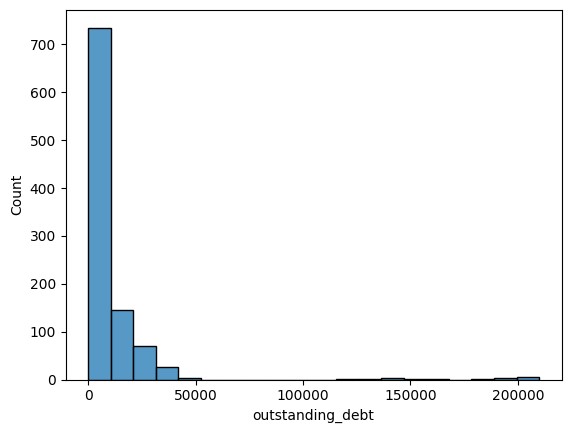

In [121]:
sn.histplot(df_credit_score_new['outstanding_debt'],bins=20)

####  Replace the outstanding amount with  credit_limit.


In [123]:
res = df_credit_score_new[df_credit_score_new['outstanding_debt'] > df_credit_score_new['credit_limit']]
res

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_group
1,2,587,0.107928,161644.0,2.0,1250.0,551-600
19,20,647,0.439132,205014.0,3.0,1500.0,601-650
25,26,758,0.250811,190838.0,2.0,60000.0,751-800
38,39,734,0.573023,122758.0,3.0,40000.0,701-750
93,94,737,0.739948,137058.0,2.0,40000.0,701-750
204,205,303,0.364360,187849.0,0.0,500.0,300-450
271,272,703,0.446886,154568.0,1.0,40000.0,701-750
301,302,722,0.608076,122402.0,4.0,40000.0,701-750
330,331,799,0.363420,208898.0,4.0,60000.0,751-800
350,351,320,0.285081,150860.0,0.0,500.0,300-450


In [124]:
def replace_amount_outstanding(row):
  if(row['outstanding_debt']>row['credit_limit']):
    return row['credit_limit']
  else:
    return row['credit_limit']
df_credit_score_new['outstanding_debt'] = df_credit_score_new.apply(replace_amount_outstanding,axis=1)

In [125]:
df_credit_score_new.loc[734]

cust_id                                731
credit_score                           626
credit_utilisation                0.762245
outstanding_debt                    1500.0
credit_inquiries_last_6_months         2.0
credit_limit                        1500.0
credit_score_group                 601-650
Name: 734, dtype: object

In [127]:
df_credit_score_new.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,589.182000,0.498950,19733.500000,1.955000,19733.500000
std,288.819436,152.284929,0.233139,24717.629112,1.414559,24717.629112
min,1.000000,300.000000,0.103761,500.000000,0.000000,500.000000
25%,250.750000,460.000000,0.293917,750.000000,1.000000,750.000000
50%,500.500000,601.500000,0.487422,1500.000000,2.000000,1500.000000
75%,750.250000,738.000000,0.697829,40000.000000,3.000000,40000.000000
max,1000.000000,799.000000,0.899648,60000.000000,4.000000,60000.000000


### merge the customer data with credit_data

In [129]:
df_customer_credit_data = df_customer.merge(df_credit_score_new,on='cust_id')
df_customer_credit_data.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,40000.0,0.0,40000.0,701-750
1,2,Anjali Pandey,Female,46.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,551-600
2,3,Aaryan Chauhan,Male,24.0,City,Freelancer,22378.0,Married,18-25,544,0.854807,1000.0,4.0,1000.0,501-550
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,1000.0,2.0,1000.0,501-550
4,5,Advait Malik,Male,46.0,City,Consultant,39406.0,Married,26-48,708,0.586151,40000.0,2.0,40000.0,701-750


## Correlation

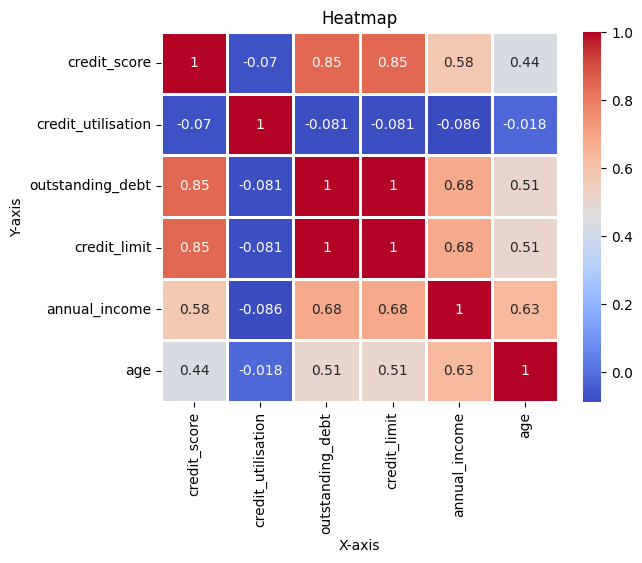

In [130]:
labels = ['credit_score','credit_utilisation','outstanding_debt','credit_limit','annual_income','age']
df_correlation = df_customer_credit_data[labels].corr()
sn.heatmap(data=df_correlation,annot=True,linewidths=0.8,cmap='coolwarm')
plt.title("Heatmap")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

<h2 style="color:pink;text-align:center">Transaction Data Statistical Analysis</h2>

In [131]:
df_transactions.shape

(500000, 7)

In [133]:
df_transactions.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [138]:
df_transactions.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [146]:
result = df_transactions.groupby('product_category',as_index=False).agg(null_count = ('platform',lambda x : x.mode()))
result

,product_category,null_count
0,Beauty & Personal Care,Amazon
1,Books,Amazon
2,Electronics,Amazon
3,Fashion & Apparel,Amazon
4,Garden & Outdoor,Amazon
5,Home Decor,Amazon
6,Kitchen Appliances,Amazon
7,Sports,Amazon
8,Toys & Games,Amazon


In [147]:
df_transactions['platform'].fillna('Amazon',inplace=True)

In [148]:
df_transactions.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

In [149]:
df_transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [160]:
df_transactions.columns

Index(['tran_id', 'cust_id', 'tran_date', 'tran_amount', 'platform',
       'product_category', 'payment_type'],
      dtype='object')

In [158]:
result = df_transactions[df_transactions['tran_amount'] == 0]
result.shape

(4734, 7)

In [161]:
zero_data = result.groupby(['platform','product_category','payment_type'],as_index=False).agg(zero_cnt = ('tran_amount',lambda x : sum(x==0)))
zero_data


,platform,product_category,payment_type,zero_cnt
0,Amazon,Electronics,Credit Card,4734


In [165]:
result_value1 = df_transactions[df_transactions['tran_amount'] > 0]

In [166]:
limit_value = result_value1[(result_value1['platform'].str.strip() == 'Amazon')&(result_value1['product_category'].str.strip() == 'Electronics')&(result_value1['payment_type'].str.strip() == 'Credit Card')]
limit_value.shape

(10903, 7)

In [169]:
median_value = limit_value.groupby(['platform','product_category','payment_type'],as_index=False).agg(mdn_value = ('tran_amount',lambda x :x.median()))['mdn_value'].values[0]
median_value

554.0

In [170]:
df_transactions.loc[df_transactions['tran_amount'] == 0,'tran_amount'] = median_value

In [172]:
result = df_transactions[df_transactions['tran_amount'] == 0]
result

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type


In [173]:
df_transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


<Axes: xlabel='tran_amount', ylabel='Count'>

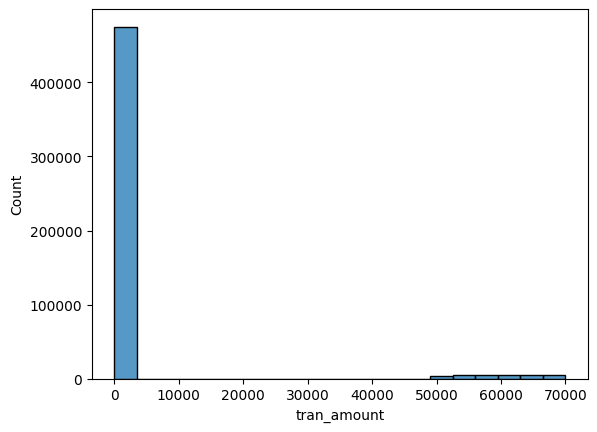

In [175]:
sn.histplot(df_transactions['tran_amount'],bins=20)

#### outlier treatment and using IQR because data is right Skewed

In [179]:
q1 = np.quantile(df_transactions['tran_amount'],0.25)
q3 = np.quantile(df_transactions['tran_amount'],0.75)
IQR = q3 - q1
Lower_range = q1 - 2*(IQR)
Upper_range = q3 + 2*(IQR)
Upper_range,Lower_range

(1107.0, -628.0)

In [181]:
df_transactions[(df_transactions['tran_amount']<Lower_range)|(df_transactions['tran_amount'] > Upper_range)].head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card


In [182]:
result = df_transactions.groupby('product_category',as_index=False).agg(product_category_median = ('tran_amount',lambda x :x.median()))
result

,product_category,product_category_median
0,Beauty & Personal Care,97.0
1,Books,31.0
2,Electronics,554.0
3,Fashion & Apparel,68.0
4,Garden & Outdoor,132.0
5,Home Decor,319.0
6,Kitchen Appliances,186.0
7,Sports,283.0
8,Toys & Games,53.0


In [185]:
def replace_amount(row):
  if((row['tran_amount']<Lower_range) | (row['tran_amount'] > Upper_range)):
    return result[result['product_category'] == row['product_category']]['product_category_median'].values[0]
  else:
    return row['tran_amount']

df_transactions['tran_amount'] = df_transactions.apply(replace_amount,axis=1)

In [186]:
df_transactions.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,241.534922
std,144337.711635,288.641924,242.364496
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,133.000000
75%,375000.250000,752.000000,349.000000
max,500000.000000,1000.000000,999.000000


## plotting the graphs for Decision Making

#### Age group vs Contribution

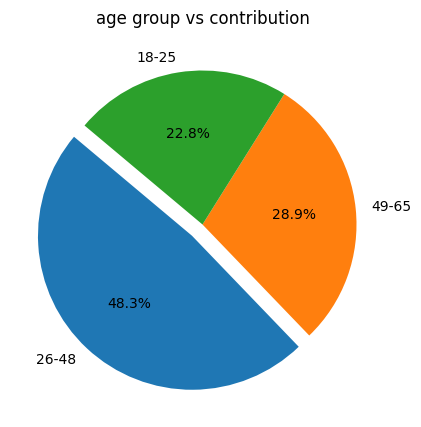

In [187]:
data = df_customer['age_group'].value_counts()
plt.figure(figsize=(8,5))
plt.pie(data.values,labels=data.index,autopct="%1.1f%%",explode=(0.1,0,0),startangle=140)
plt.title("age group vs contribution")
plt.show()

In [188]:
df_final = df_customer_credit_data.merge(df_transactions,on='cust_id')
df_final.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_group,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,40000.0,0.0,40000.0,701-750,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,40000.0,0.0,40000.0,701-750,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,40000.0,0.0,40000.0,701-750,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay
3,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,40000.0,0.0,40000.0,701-750,1576,2023-01-01,149.0,Amazon,Beauty & Personal Care,Phonepe
4,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,40000.0,0.0,40000.0,701-750,1757,2023-01-01,37.0,Flipkart,Fashion & Apparel,Credit Card


#### Annual income by age group

C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\1589605588.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_final.groupby('age_group',as_index=False).agg(mean_annual_salary = ('annual_income',lambda x : x.mean()))
C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\1589605588.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  result = sn.barplot(data=data,x=data['age_group'],y=data['mean_annual_salary'],palette='colorblind')


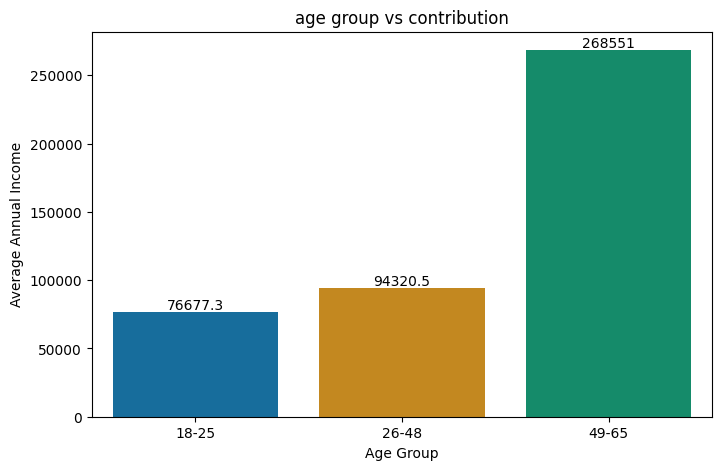

In [190]:
data = df_final.groupby('age_group',as_index=False).agg(mean_annual_salary = ('annual_income',lambda x : x.mean()))
plt.figure(figsize=(8,5))
result = sn.barplot(data=data,x=data['age_group'],y=data['mean_annual_salary'],palette='colorblind')
for value in result.containers:
  result.bar_label(value)
plt.xlabel('Age Group')
plt.ylabel('Average Annual Income')
plt.title("age group vs contribution")
plt.show()

C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\2152426117.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_final.groupby('age_group',as_index=False).agg(max_credit_limit = ('credit_limit','mean'))
C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\2152426117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  result = sn.barplot(data=data,x=data['age_group'],y=data['max_credit_limit'],palette='colorblind')


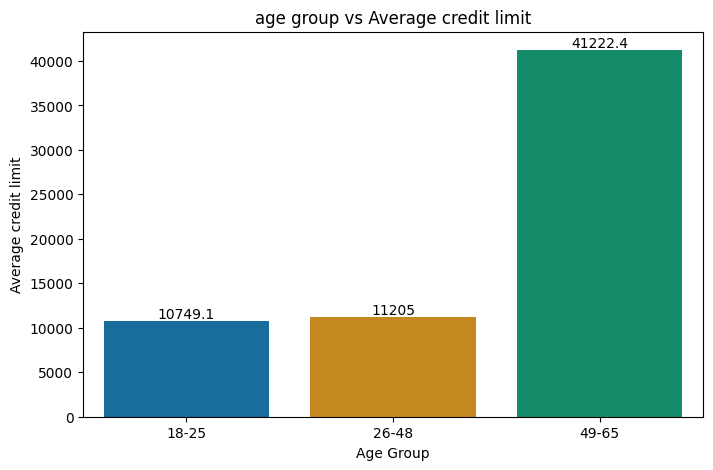

In [196]:
data = df_final.groupby('age_group',as_index=False).agg(max_credit_limit = ('credit_limit','mean'))
plt.figure(figsize=(8,5))
result = sn.barplot(data=data,x=data['age_group'],y=data['max_credit_limit'],palette='colorblind')
for value in result.containers:
  result.bar_label(value)
plt.xlabel('Age Group')
plt.ylabel('Average credit limit')
plt.title("age group vs Average credit limit")
plt.show()

C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\3457897915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_final.groupby('age_group',as_index=False).agg(average_credit_score = ('credit_score','mean'))
C:\Users\mmadhu9\AppData\Local\Temp\ipykernel_19740\3457897915.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  result = sn.barplot(data=data,x=data['age_group'],y=data['average_credit_score'],palette='colorblind')


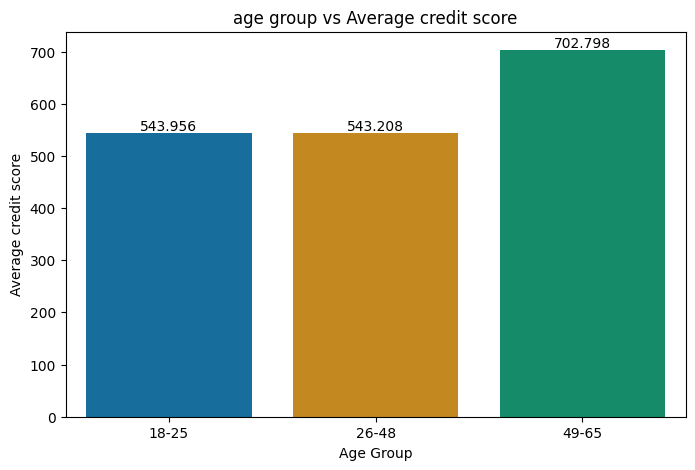

In [198]:
data = df_final.groupby('age_group',as_index=False).agg(average_credit_score = ('credit_score','mean'))
plt.figure(figsize=(8,5))
result = sn.barplot(data=data,x=data['age_group'],y=data['average_credit_score'],palette='colorblind')
for value in result.containers:
  result.bar_label(value)
plt.xlabel('Age Group')
plt.ylabel('Average credit score')
plt.title("age group vs Average credit score")
plt.show()

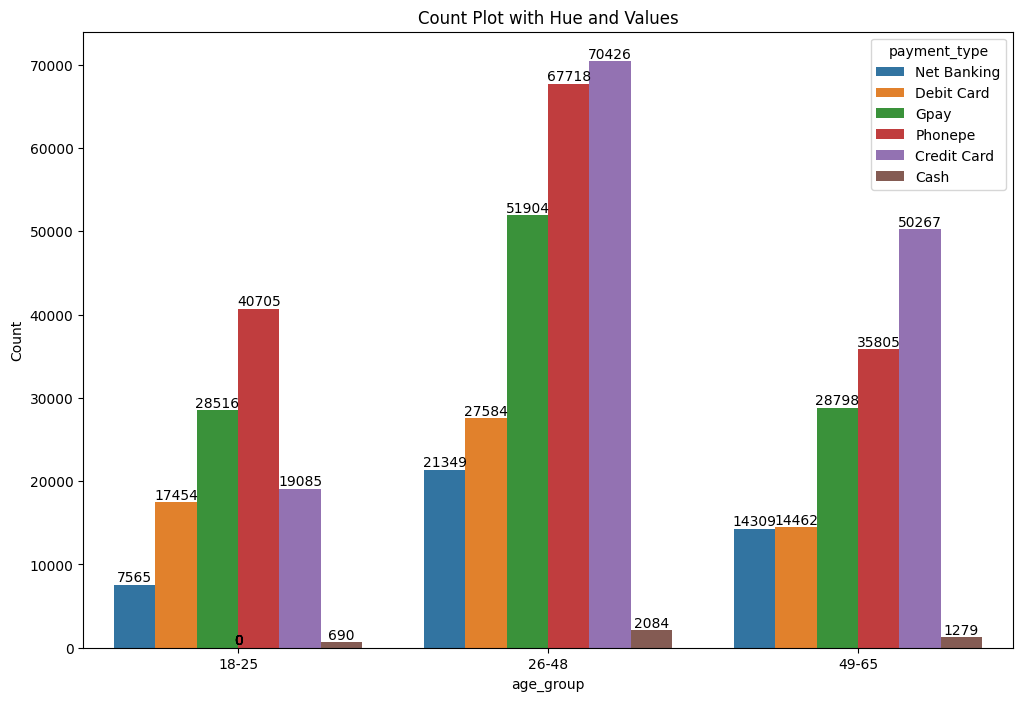

In [ ]:
plt.figure(figsize=(12,8))
ax = sn.countplot(data=df_final, x='age_group', hue='payment_type')
# Annotate the bars with the counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Distribution of payment type across age group')
plt.ylabel('Count')
plt.show()

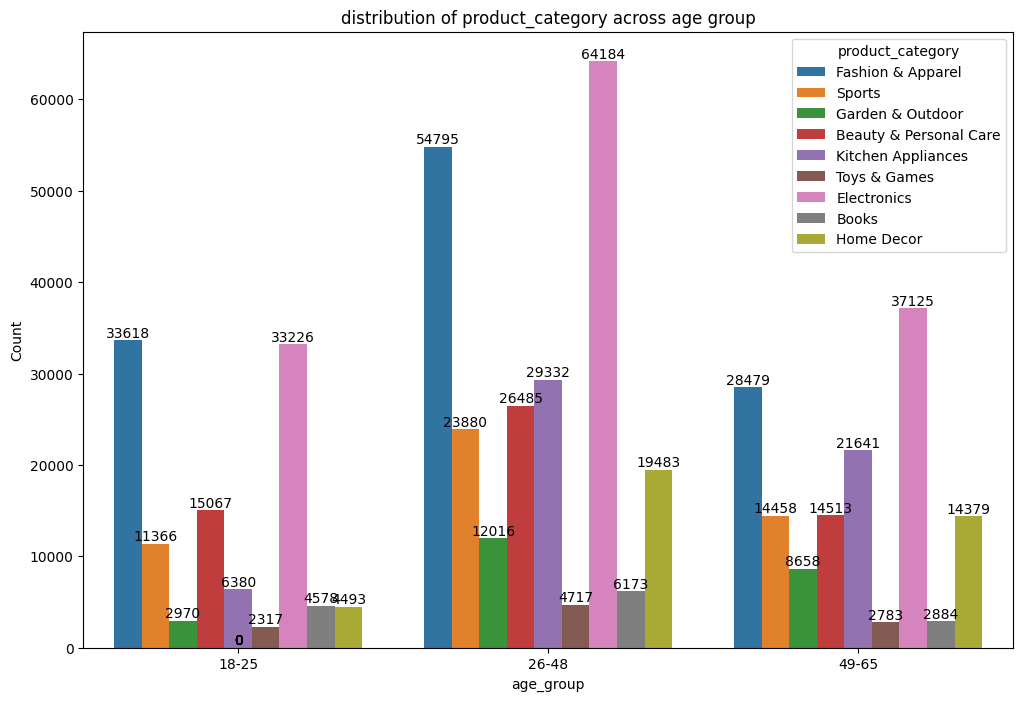

In [201]:
plt.figure(figsize=(12,8))
ax = sn.countplot(data=df_final, x='age_group', hue='product_category')
# Annotate the bars with the counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('distribution of product_category across age group')
plt.ylabel('Count')
plt.show()

<h1 style = "color : pink;text-align : center">AB Testing on both new and old credit Card Data</h1>

### Sample size splitup

In [214]:
df_avg_transactions_after_campaign.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,251.02,401.78
1,2023-09-11,250.77,326.16
2,2023-09-12,248.81,303.92
3,2023-09-13,255.90,363.29
4,2023-09-14,255.86,317.06


In [217]:
df_avg_transactions_after_campaign[df_avg_transactions_after_campaign['control_group_avg_tran'] < df_avg_transactions_after_campaign['test_group_avg_tran']].shape[0]/df_avg_transactions_after_campaign.shape[0]*100

96.7741935483871

In [202]:
alpha = 0.05
power = 0.8
effective_size = 0.2

sms.tt_ind_solve_power(
  effect_size=effective_size,
  alpha=alpha,
  power=power,ratio=1,alternative="two-sided"
)

393.4056989990351

In [204]:
effective_sizes = [0.1,0.2,0.3,0.4,0.5,1]
for i in effective_sizes:
  result = sms.tt_ind_solve_power(
  effect_size=i,
  alpha=alpha,
  power=power,ratio=1,alternative="two-sided"
)
  print(f'effective size {i}  and sample size id {result}')

effective size 0.1  and sample size id 1570.733066331601
effective size 0.2  and sample size id 393.4056989990351
effective size 0.3  and sample size id 175.38467227482175
effective size 0.4  and sample size id 99.08032683981116
effective size 0.5  and sample size id 63.76561177540986
effective size 1  and sample size id 16.714722572276195


#### Decide the sample size is 100

In [205]:
df_avg_transactions_after_campaign.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,251.02,401.78
1,2023-09-11,250.77,326.16
2,2023-09-12,248.81,303.92
3,2023-09-13,255.90,363.29
4,2023-09-14,255.86,317.06


<Axes: xlabel='control_group_avg_tran', ylabel='Count'>

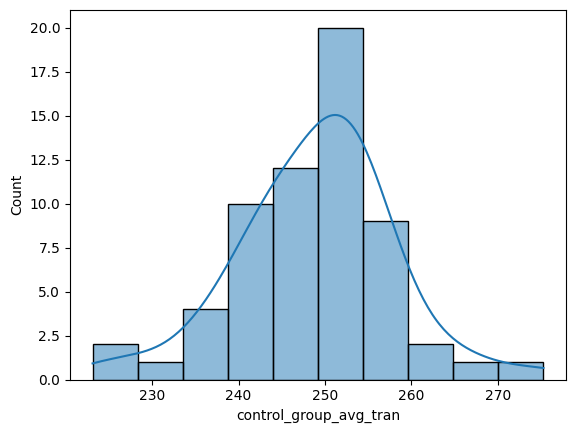

In [207]:
sn.histplot(df_avg_transactions_after_campaign['control_group_avg_tran'],kde=True)

<Axes: xlabel='test_group_avg_tran', ylabel='Count'>

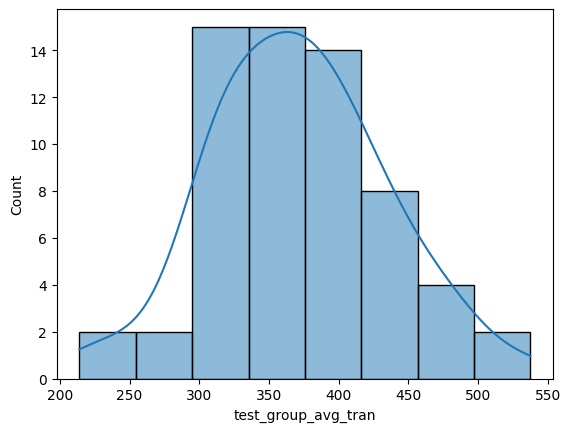

In [208]:
sn.histplot(df_avg_transactions_after_campaign['test_group_avg_tran'],kde=True)

### Step : 1 Decide the Hypothesis 

### H0 = New Credit does not make the Transaction better than the old
### H1 = New Credit make the Transaction better than the old

In [209]:
z_critical = st.norm.ppf(1-alpha)
z_critical

1.6448536269514722

In [211]:
control_data_mean = df_avg_transactions_after_campaign['control_group_avg_tran'].mean()
control_data_std = df_avg_transactions_after_campaign['control_group_avg_tran'].std()
control_data_sample_size = df_avg_transactions_after_campaign.shape[0]
control_data_mean,control_data_std,control_data_sample_size

(248.94129032258064, 9.137869049553624, 62)

In [210]:
Test_data_mean = df_avg_transactions_after_campaign['test_group_avg_tran'].mean()
Test_data_std = df_avg_transactions_after_campaign['test_group_avg_tran'].std()
Test_data_sample_size = df_avg_transactions_after_campaign.shape[0]
Test_data_mean,Test_data_std,Test_data_sample_size

(370.5364516129033, 63.25415113953286, 62)

In [212]:
a = control_data_std**2/control_data_sample_size
b = Test_data_std**2/control_data_sample_size
z_score = (Test_data_mean - control_data_mean) / np.sqrt(a+b)
z_score

14.98090307099052

In [213]:
z_score > z_critical

True

#### From the above Result Z_score is higher than the Z_critical , we have proper evidence to reject the null hypothesis and from the above testing we can conclude that 
#### New Credit makes the better Transaction than Old credit card and we happy to suggest that to launch the new Credit card 